# Модель для определения возраста по фотографии

**Контекст**

Для обучения модели использована база данных APPA-REAL, которая содержит 7 591 изображений с метками реального возраста

https://www.kaggle.com/abhikjha/appa-real-face-cropped


# 1. Исследовательский анализ данных

## 1) Загрузим библиотеки

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

## 2) Загрузим датасет с метками в переменную lables, извлечем изображения из папки

In [2]:
labels = pd.read_csv('/kaggle/input/appa-real-face-cropped/labels.csv')
path = '/kaggle/input/appa-real-face-cropped/final_files/final_files'

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
train_datagen = ImageDataGenerator(rescale=1/255.)

In [5]:
train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                       directory=path,
                                                       x_col='file_name',
                                                       y_col='real_age',
                                                       target_size=(224, 224),
                                                       batch_size=32,
                                                       class_mode='raw',
                                                       seed = 42)

Found 7591 validated image filenames.


**Вывод:**
1. В датасете 7591 строка, нет пропущенных значений: исходя из представленных данных, в колонке file_name - информация о названии файлов, в колонке real_age - возраст изображенного на фото человека.
2. Загрузчик нашёл 7591 изображение, которые размещены в одной папке.

## 3) Выведем описательную статистику о датасете, посчитаем сколько уникальных возрастов в датасете, построим график распределения возраста в выборке

#### - описательная статистика

In [6]:
labels.describe().T

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


#### - посчитаем сколько уникальных возрастов в датасете

In [7]:
len(labels.real_age.unique())

97

#### - построим график распределения возраста в выборке

Text(0.5, 1.0, 'График распределения возраста в выборке')

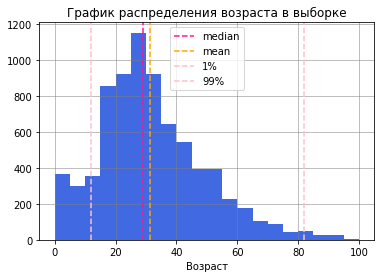

In [8]:
_, ax = plt.subplots()

ax.hist(labels.real_age, bins=20, range=(0, 100), cumulative=False, color='#4169E1')
ax.grid(color='grey', linestyle='-', linewidth=0.5)

ax.axvline(labels.real_age.median(), linestyle='--', color='#FF1493', label='median')
ax.axvline(labels.real_age.mean(), linestyle = '--', color = 'orange', label='mean')
ax.axvline(labels.real_age.quantile(0.1), linestyle='--', color='pink', label='1%')
ax.axvline(labels.real_age.quantile(0.99), linestyle='--', color='pink', label='99%')
ax.legend()
ax.set_xlabel('Возраст')
ax.set_title('График распределения возраста в выборке')

#### - построим boxplot

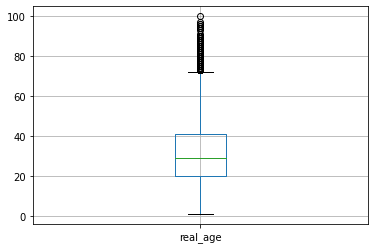

In [9]:
labels.boxplot('real_age')

**Вывод:**
1. В представленной выборке 97 уникальных значений возраста в отношении 7591 наблюдения:
    - минимальный возраст - 1 год,
    - максимальный возраст - 100 лет,
    - средний возраст - 31 год.
2. Распределение ассиметрично, скошено вправо, пик в районе 30 лет, есть длинный хвост.
3. В датасете есть выбросы, которые влияют на медиану, но которые при этом являются частью явления и важны для наблюдения.

## 4) Напечатаем на экране 15 изображений:

#### - получим объект с парами "изображения — метки" для печати изображений

In [10]:
features, target = next(train_datagen_flow)

In [11]:
features.shape

(32, 224, 224, 3)

Признаки — четырёхмерный тензор, в котором 32 изображения размером 224x224 с тремя цветовыми каналами.

#### - выведем фотографии на экран

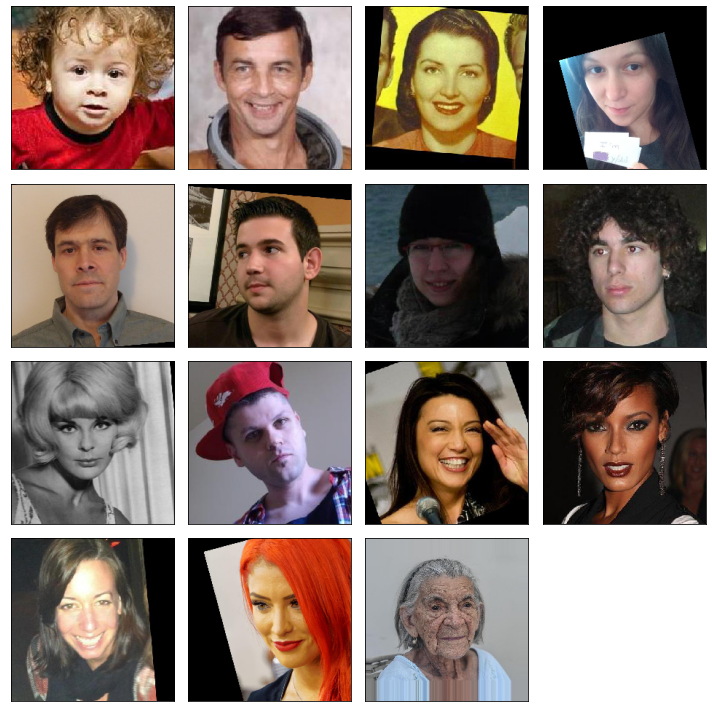

In [12]:
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

#### - освободим память от датасета за ненадобностью

In [13]:
del train_datagen_flow

## Вывод:

1. В представленной выборке 7591 наблюдение без проблем в данных, которому соответсвует 7591 изображение, размещенное в одной папке.
2. В представленной выборке 97 значений возраста - от 1 года до 100 лет, со средним возрастом 31 год.
3. Распределение ассиметрично, скошено вправо, есть выбросы, которые являются частью явления и должны быть сохранены, так как есть разница между различными возрастами и, с точки зрения поставленной задачи, потребности в товарах зависят от возраста.
4. Полагаю, целесообразно трансформировать (или дополнить) регрессионную задачу в задачу классификации и рассматривать покупателей как обособленные возрастные группы, поскольку именно группы отличаются необходимыми устойчивыми характеристиками (экономические, психологические, поведенческие и другие), которые позволяют применять рекламу как эффективный инструмент.
5. Контроль за кассирами с помощью модели представляется неэффективным: продажа алкоголя в пограничных с разрешенным возрастом случаях следует рассматривать скорее как ненамеренную ошибку восприятия (покупатель просто обманул внешним видом и уверенностью). Даже если такой случай будет выявлен с помощью модели, результат будет предположительным и спорным. 
6. Представляется, что для профилактики продажи алгоколя в пограничных случаях достаточно приучить кассира спрашивать паспорт перед продажей в случае сомнений. 
7. Если кассир продает алкоголь в случаях, когда возраст очевидно ниже разрешенного - решение с помощью модели представляется бесцельным и расточительным. Эффективнее наблюдение, если уже возникли подозрения в недобросовестности, и меры дисциплинарного характера.
5. Исходя из напечатанных фотографий - в папке с изобрадениями собраны стоковые изображения людей, с деформацией (повороты, искажения, отсутствие или искажение цвета), шумами, различным освещением, что, вероятно, снизит качество модели.

# 2. Обучение модели

## 1) Код модели

In [14]:
def load_train(path, labels):

    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
 
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                           directory=path,
                                                           x_col='file_name',
                                                           y_col='real_age',
                                                           target_size=(224, 224),
                                                           batch_size=32,
                                                           subset='training',
                                                           class_mode='raw',
                                                           seed = 42)
 
    return train_datagen_flow

def load_test(path, labels):

    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)

    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
                                                         directory=path,
                                                         x_col='file_name',
                                                         y_col='real_age',
                                                         target_size=(224, 224),
                                                         batch_size=32,
                                                         subset='validation',
                                                         class_mode='raw',
                                                         seed = 42)
 
    return test_datagen_flow
 
 
def create_model(input_shape):
 
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(512, activation='relu'))    
    model.add(Dense(1, activation='relu'))
 
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
 
 
    return model
 
def train_model(model, train_data, test_data, batch_size=None, epochs=3,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

## 2) Обучение модели

#### - переменная с размером признаков

In [15]:
input_shape = (224, 224, 3)

#### - загрузим обучающю и тестовую выборки

In [16]:
train_data = load_train(path, labels)

Found 5694 validated image filenames.


In [17]:
test_data = load_test(path, labels)

Found 1897 validated image filenames.


#### - создадим модель

In [18]:
model = create_model(input_shape)

94773248/94765736 [==============================] - 3s 0us/step


#### - обучим модель

In [19]:
train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None)

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 66s - loss: 223.0814 - mae: 10.6772 - val_loss: 628.6228 - val_mae: 19.9982
Epoch 2/10
178/178 - 51s - loss: 56.9332 - mae: 5.7869 - val_loss: 565.3187 - val_mae: 18.6335
Epoch 3/10
178/178 - 51s - loss: 27.5392 - mae: 4.0321 - val_loss: 270.7311 - val_mae: 12.3047
Epoch 4/10
178/178 - 51s - loss: 17.8313 - mae: 3.1811 - val_loss: 150.5226 - val_mae: 9.4489
Epoch 5/10
178/178 - 61s - loss: 13.0456 - mae: 2.6848 - val_loss: 91.6994 - val_mae: 7.1267
Epoch 6/10
178/178 - 51s - loss: 10.7133 - mae: 2.4457 - val_loss: 78.6793 - val_mae: 6.6862
Epoch 7/10
178/178 - 51s - loss: 9.4084 - mae: 2.2689 - val_loss: 70.3694 - val_mae: 6.4171
Epoch 8/10
178/178 - 51s - loss: 7.9534 - mae: 2.0964 - val_loss: 68.5964 - val_mae: 6.2505
Epoch 9/10
178/178 - 113s - loss: 7.1654 - mae: 1.9464 - val_loss: 74.2177 - val_mae: 6.4074
Epoch 10/10
178/178 - 51s - loss: 6.8280 - mae: 1.9135 - val_loss: 76.4187 - val_mae: 6.5085


# 3. Анализ обученной модели

1. Для обучения модели был использован датасет с 7591 изображением.
2. Датасет был разделен на обучающую и тестовые выборки в соотношении 75:25.
3. При загрузке датасета не использовалась аугментация в какой-либо форме.
4. Для обучения была использована предобученная на ImageNet модель архитектуры ResNet50, которая позволила уменьшить проблемы с недообучением и оптимизацией модели.
5. Дополнительно к ResNet50 в модель был добавлен полносвязный слой с 512 нейронами и функцией активации 'ReLU', и выходной слой с одним нейроном и функцией активации 'ReLU'.
6. В качестве функции потерь использовано Mean Squared Error, метрикой избрано Mean Absolute Error.
7. Результат модели:
    - МАЕ на тренировочной выборке - 1.9135,
    - МАЕ на тестовой выборке - 6.5085